# Análise de Componentes Principais (PCA)

## 1. Definição das propriedades a serem utilizadas

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import cv2

def get_area(img):
    '''Calcula a área do objeto contido em img'''
    
    return np.sum(img)

def get_perimeter(img):
    '''Calcula o perímetro do objeto contido em img utilizando contagem simples
       de pixels'''
    
    elem_est = np.ones((3, 3))
    img_eroded = ndi.binary_erosion(img, elem_est)
    img_border = img - img_eroded
    perimeter = np.sum(img_border)    
        
    return perimeter

def get_circularity(img):
    '''Calcula circularidade do objeto contido em img'''
    
    area = get_area(img)
    perimeter = get_perimeter(img)
    
    circularity = 4*np.pi*area/perimeter**2
    
    return circularity    

def get_centroid(img):
    '''Calcula a posição do centróide do objeto contido em img'''
    
    num_rows, num_cols = img.shape
    sum_row_coords = 0
    sum_col_coords = 0
    num_pixels = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if img[row, col]==1:
                sum_row_coords += row
                sum_col_coords += col
                num_pixels += 1
                
    avg_row = sum_row_coords/num_pixels
    avg_col = sum_col_coords/num_pixels
    
    # Utilizando numpy
    # pixel_indices = np.nonzero(img==1)
    # avg_row = np.mean(pixel_indices[0])
    # avg_col = np.mean(pixel_indices[1])
       
    return avg_row, avg_col
    
def get_distance_to_centroid(img):
    '''Calcula a distância entre cada ponto de contorno e
       o centróide do objeto contido em img'''
    
    avg_row, avg_col = get_centroid(img)
    contour = get_parametric_contour_opencv(img)
    dist_to_centroid = np.zeros(len(contour))
    for point_index, point in enumerate(contour):
        dist = np.sqrt((point[0]-avg_col)**2 + (point[1]-avg_row)**2)
        dist_to_centroid[point_index] = dist
        
    # Utilizadno numpy
    # contour = np.array(contour)
    # dist_to_centroid = np.sqrt((contour[:,0]-avg_col)**2 + (contour[:,1]-avg_row)**2)
        
    return dist_to_centroid

def get_parametric_contour_opencv(img):
    '''Obtém o contorno paramétrico do objeto contido em img
       utilizando a biblioteca opencv. Note que o contorno retornado
       pela função é uma lista de posições. O primeiro valor de cada
       posição é a coordenada da coluna e o segundo a coordenada da linha'''
    
    # Preenche imagem com zeros
    img_pad = np.pad(img, 1, mode='constant')
    
    # cv2.RETR_EXTERNAL significa que apenas o contorno mais externo dos objetos 
    # será obtido (buracos dentro do objeto são ignorados). cv2.CHAIN_APPROX_NONE
    # significa que todos os pontos do contorno serão retornados (é possível obter
    # somente os vértices de um polígono representa o contorno).
    contour = cv2.findContours(img_pad, mode=cv2.RETR_EXTERNAL, 
                               method=cv2.CHAIN_APPROX_NONE)[1]
    
    # O contorno retornado pelo OpenCV possui um formato bem estranho.
    # O loop abaixo rearranja os pontos de forma a gerar uma lista simples de pontos
    contour = [(point[0][0]-1, point[0][1]-1) for point in contour[0]]
    
    return contour

def get_distance_to_centroid_props(dist_to_centroid):
    '''Obtém algumas propriedades de um objeto a partir de uma lista de
       distâncias entre os pontos de contorno e o centróide do mesmo'''
    
    avg_dist_to_centroid = np.mean(dist_to_centroid)
    max_dist_to_centroid = np.max(dist_to_centroid)/avg_dist_to_centroid
    min_dist_to_centroid = np.min(dist_to_centroid)/avg_dist_to_centroid
    std_dist_to_centroid = np.std(dist_to_centroid)/avg_dist_to_centroid
    
    return max_dist_to_centroid, min_dist_to_centroid, std_dist_to_centroid

def correct_image(img):
    '''Corrige dois problems observados na base de dados: 1. Algumas imagens
       apresentam conjuntos de pixels brancos separados do objeto principal. 
       Portanto precisamos encontrar e manter apenas o maior componente conexo
       nessas imagens. 2. Em algumas imagens, o objeto não está preenchido.
       Portanto, precisamos preenchê-los.'''
    
    # Obtenção do maior componente conexo utilizando funções do scipy
    img_lab, num_comp = ndi.label(img, np.ones((3,3)))
    tam_comps = ndi.sum(img, img_lab, range(1, num_comp+1))
    index_largest_comp = np.argmax(tam_comps) + 1
    img_largest_comp = img_lab==index_largest_comp

    # Obtenção do maior componente conexo de background. A ideia é
    # que buracos no interior do objeto representam componentes conexos
    # pequenos, que serão eliminados se apenas o maior componente de
    # background for mantido
    img_inv = np.logical_not(img_largest_comp)   # Inverte a imagem
    img_lab, num_comp = ndi.label(img_inv, np.ones((3,3)))
    tam_comps = ndi.sum(img_inv, img_lab, range(1, num_comp+1))
    index_largest_comp = np.argmax(tam_comps) + 1
    img_largest_comp_filled = img_lab==index_largest_comp 
    
    # Inverte novamente a imagem
    img_largest_comp_filled = np.logical_not(img_largest_comp_filled)  
    
    return img_largest_comp_filled.astype(np.uint8)
      

## 2. Obtenção das propriedades das imagens da base

In [2]:
input_folder = 'imagens/'
files = os.listdir(input_folder)    # Lista todos os arquivos no diretório input_folder
num_files = len(files)

measurements = np.zeros((num_files, 4))
for file_index, file in enumerate(files):
    img = plt.imread(input_folder+file)
    img = (img>0).astype(np.uint8)
    
    # Se a imagem possuir 3 dimensões, é porque ela não possui apenas
    # 1 canal. Nesse caso, mantemos apenas o primeiro canal
    if img.ndim==3:
        img = img[:,:,0]
    
    img_corrected = correct_image(img)
    
    circularity = get_circularity(img_corrected)
    dist_to_centroid = get_distance_to_centroid(img_corrected)
    props = get_distance_to_centroid_props(dist_to_centroid)
    max_dist_to_centroid, min_dist_to_centroid, std_dist_to_centroid = props
    
    measurements[file_index] = [circularity, max_dist_to_centroid, 
                                min_dist_to_centroid, std_dist_to_centroid]
    

A variável measurements é uma matriz na qual cada linha representa uma imagem e cada coluna uma propriedade calculada. Ou seja, cada linha dessa matriz representa uma imagem localizada em um espaço de atributos 4 dimensões (pois a matriz tem 4 colunas).

## 3. Aplicação do PCA implementado na biblioteca scikit-learn

Vamos aplicar o PCA para definir 2 novos atributos. Veremos se esses 2 atributos podem ser utilizados para separar as duas categorias de imagens.

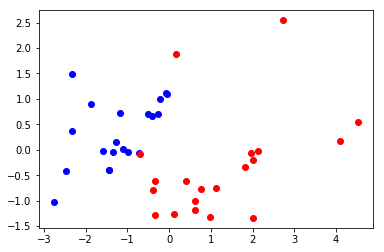

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale    # z-score

# Normaliza medidas, de forma que cada coluna de measurements_norm
# possui média 0 e desvio padrão 1
measurements_norm = scale(measurements, axis=0)

# Cria instância da classe PCA, com projeção em 2 eixos (2D), e aplica
# o PCA nos dados
pca_instance = PCA(n_components=2)
proj_data = pca_instance.fit_transform(measurements_norm)

# Plota cada metade dos pontos com uma cor diferente
plt.plot(proj_data[:20,0], proj_data[:20,1], 'bo')
plt.plot(proj_data[20:,0], proj_data[20:,1], 'ro')